In [1]:
import requests
import pandas as pd
import json
from pandas.io.json import json_normalize
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%store -r api_key

# DATA WRANGLING

In [ ]:
# Get list of all game ids from 2013 to 2017

years = [2013,2014,2015,2016,2017]

game_ids = {}

for year in years:

    schedule_url = 'http://api.sportradar.us/nba/trial/v5/en/games/{}/REG/schedule.json?api_key={}'.format(year, api_key)

    schedule = requests.get(schedule_url).json()
    
    for game in schedule['games']:
        
        game_ids[game['id']] = year
        
    time.sleep(5)
    
game_ids

In [164]:
# Initialize game summary statistics DataFrame with first game id in game_ids dictionary

game_summary_url = 'http://api.sportradar.us/nba/trial/v5/en/games/{}/summary.json?api_key={}'.format(list(game_ids.keys())[0], api_key)
game_data = requests.get(game_summary_url)

game_data_json = game_data.json()
game_data_json = json_normalize(game_data_json, errors='ignore')
df_all_games = pd.DataFrame.from_dict(game_data_json, orient='columns')
df_all_games


In [217]:
# Starting with the second game in game_ids dictionary, add all game summary data to DataFrame

for game in list(game_ids.keys())[1:]:
    
    game_summary_url = 'http://api.sportradar.us/nba/trial/v5/en/games/{}/summary.json?api_key={}'.format(game, api_key)
    game_data = requests.get(game_summary_url)
    
# Try to normalize the json, first replacing all nulls with 0. If there is an exception raised, print it and break from the loop.

    try:
        game_data_json = game_data.json()
        game_data_json = json.loads(json.dumps(game_data_json).replace("null", '0'))
        game_data_json = json_normalize(game_data_json, errors='ignore')
    
        df_game = pd.DataFrame.from_dict(game_data_json, orient='columns')
        df_all_games = pd.concat([df_all_games, df_game], ignore_index=True, sort=True)
        
    except Exception as e:
        print(game)
        print(game_data)
        print(e)
        break
        

    time.sleep(1)    

In [2]:
# Create DataFrame using read_csv in case connection to Jupyter is lost

df_all_games = pd.read_csv('df_all_games.csv')

C:\Users\Taylor\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,78,88,93,168,179,186,187,188) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# DATA CLEANING

In [3]:
# Choose relevant columns of df_all_games to keep for analysis

cols_keep = ['id', 'away.points', 'away.rank', 'home.points','home.rank']
cols_home = [col for col in df_all_games.columns if col.startswith('home.statistics')]
cols_away = [col for col in df_all_games.columns if col.startswith('away.statistics')]

cols_keep.extend(cols_home)
cols_keep.extend(cols_away)

df_all_games_new = df_all_games[cols_keep]
pd.set_option('display.max_columns', 200)
df_all_games_new.head()



,id,away.points,away.rank,home.points,home.rank,home.statistics.assists,home.statistics.assists_turnover_ratio,home.statistics.bench_points,home.statistics.biggest_lead,home.statistics.blocked_att,home.statistics.blocks,home.statistics.coach_ejections,home.statistics.coach_tech_fouls,home.statistics.defensive_points_per_possession,home.statistics.defensive_rating,home.statistics.defensive_rebounds,home.statistics.effective_fg_pct,home.statistics.efficiency,home.statistics.efficiency_game_score,home.statistics.ejections,home.statistics.fast_break_att,home.statistics.fast_break_made,home.statistics.fast_break_pct,home.statistics.fast_break_pts,home.statistics.field_goals_att,home.statistics.field_goals_made,home.statistics.field_goals_pct,home.statistics.flagrant_fouls,home.statistics.foulouts,home.statistics.fouls_drawn,home.statistics.free_throws_att,home.statistics.free_throws_made,home.statistics.free_throws_pct,home.statistics.minutes,home.statistics.most_unanswered.opp_score,home.statistics.most_unanswered.own_score,home.statistics.most_unanswered.points,home.statistics.offensive_fouls,home.statistics.offensive_points_per_possession,home.statistics.offensive_rating,home.statistics.offensive_rebounds,home.statistics.opponent_possessions,home.statistics.periods,home.statistics.personal_fouls,home.statistics.player_tech_fouls,home.statistics.pls_min,home.statistics.points,home.statistics.points_against,home.statistics.points_in_paint,home.statistics.points_in_paint_att,home.statistics.points_in_paint_made,home.statistics.points_in_paint_pct,home.statistics.points_off_turnovers,home.statistics.possessions,home.statistics.rebounds,home.statistics.second_chance_att,home.statistics.second_chance_made,home.statistics.second_chance_pct,home.statistics.second_chance_pts,home.statistics.steals,home.statistics.team_defensive_rebounds,home.statistics.team_fouls,home.statistics.team_offensive_rebounds,home.statistics.team_rebounds,home.statistics.team_tech_fouls,home.statistics.team_turnovers,home.statistics.three_points_att,home.statistics.three_points_made,home.statistics.three_points_pct,home.statistics.time_leading,home.statistics.total_fouls,home.statistics.total_rebounds,home.statistics.true_shooting_att,home.statistics.true_shooting_pct,home.statistics.turnovers,home.statistics.two_points_att,home.statistics.two_points_made,home.statistics.two_points_pct,away.statistics.assists,away.statistics.assists_turnover_ratio,away.statistics.bench_points,away.statistics.biggest_lead,away.statistics.blocked_att,away.statistics.blocks,away.statistics.coach_ejections,away.statistics.coach_tech_fouls,away.statistics.defensive_points_per_possession,away.statistics.defensive_rating,away.statistics.defensive_rebounds,away.statistics.effective_fg_pct,away.statistics.efficiency,away.statistics.efficiency_game_score,away.statistics.ejections,away.statistics.fast_break_att,away.statistics.fast_break_made,away.statistics.fast_break_pct,away.statistics.fast_break_pts,away.statistics.field_goals_att,away.statistics.field_goals_made,away.statistics.field_goals_pct,away.statistics.flagrant_fouls,away.statistics.foulouts,away.statistics.fouls_drawn,away.statistics.free_throws_att,away.statistics.free_throws_made,away.statistics.free_throws_pct,away.statistics.minutes,away.statistics.most_unanswered.opp_score,away.statistics.most_unanswered.own_score,away.statistics.most_unanswered.points,away.statistics.offensive_fouls,away.statistics.offensive_points_per_possession,away.statistics.offensive_rating,away.statistics.offensive_rebounds,away.statistics.opponent_possessions,away.statistics.periods,away.statistics.personal_fouls,away.statistics.player_tech_fouls,away.statistics.pls_min,away.statistics.points,away.statistics.points_against,away.statistics.points_in_paint,away.statistics.points_in_paint_att,away.statistics.points_in_paint_made,away.statistics.points_in_paint_pct,away.statistics.points_off_turnovers,away.statistics.possessions,away.statistics.rebou

In [4]:
df_all_games_new.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6166 entries, 0 to 6165
Data columns (total 151 columns):
id                                                 6166 non-null object
away.points                                        6162 non-null float64
away.rank                                          8 non-null float64
home.points                                        6162 non-null float64
home.rank                                          8 non-null float64
home.statistics.assists                            6159 non-null float64
home.statistics.assists_turnover_ratio             6159 non-null float64
home.statistics.bench_points                       2463 non-null float64
home.statistics.biggest_lead                       2463 non-null float64
home.statistics.blocked_att                        6159 non-null float64
home.statistics.blocks                             6159 non-null float64
home.statistics.coach_ejections                    1180 non-null float64
home.statistics.coach_t

In [5]:
# Choose columns with at least 6000 non-null values

cols_with_high_counts = [col for col in df_all_games_new.columns if df_all_games_new[col].count() > 6000]
df_all_games_new = df_all_games_new[cols_with_high_counts]

df_all_games_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6166 entries, 0 to 6165
Data columns (total 75 columns):
id                                           6166 non-null object
away.points                                  6162 non-null float64
home.points                                  6162 non-null float64
home.statistics.assists                      6159 non-null float64
home.statistics.assists_turnover_ratio       6159 non-null float64
home.statistics.blocked_att                  6159 non-null float64
home.statistics.blocks                       6159 non-null float64
home.statistics.coach_tech_fouls             6159 non-null float64
home.statistics.defensive_rebounds           6159 non-null float64
home.statistics.fast_break_pts               6137 non-null float64
home.statistics.field_goals_att              6159 non-null float64
home.statistics.field_goals_made             6159 non-null float64
home.statistics.field_goals_pct              6159 non-null float64
home.statistics.flagran

In [6]:
# Drop columns that are not of interest from new column list

strings_to_drop = ('blocked_att','tech_fouls','flagrant_fouls', 'minutes', 'team_rebounds', 'team_turnovers', 'score')
cols_to_keep = [col for col in df_all_games_new.columns if not col.endswith(strings_to_drop)]
df_all_games_new = df_all_games_new[cols_to_keep]
df_all_games_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6166 entries, 0 to 6165
Data columns (total 55 columns):
id                                        6166 non-null object
away.points                               6162 non-null float64
home.points                               6162 non-null float64
home.statistics.assists                   6159 non-null float64
home.statistics.assists_turnover_ratio    6159 non-null float64
home.statistics.blocks                    6159 non-null float64
home.statistics.defensive_rebounds        6159 non-null float64
home.statistics.fast_break_pts            6137 non-null float64
home.statistics.field_goals_att           6159 non-null float64
home.statistics.field_goals_made          6159 non-null float64
home.statistics.field_goals_pct           6159 non-null float64
home.statistics.free_throws_att           6159 non-null float64
home.statistics.free_throws_made          6159 non-null float64
home.statistics.free_throws_pct           6159 non-null float6

In [7]:
# Keep only those rows where all entries are non-null

df_all_games_new = df_all_games_new[df_all_games_new.notnull().all(1)]
df_all_games_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6094 entries, 0 to 6165
Data columns (total 55 columns):
id                                        6094 non-null object
away.points                               6094 non-null float64
home.points                               6094 non-null float64
home.statistics.assists                   6094 non-null float64
home.statistics.assists_turnover_ratio    6094 non-null float64
home.statistics.blocks                    6094 non-null float64
home.statistics.defensive_rebounds        6094 non-null float64
home.statistics.fast_break_pts            6094 non-null float64
home.statistics.field_goals_att           6094 non-null float64
home.statistics.field_goals_made          6094 non-null float64
home.statistics.field_goals_pct           6094 non-null float64
home.statistics.free_throws_att           6094 non-null float64
home.statistics.free_throws_made          6094 non-null float64
home.statistics.free_throws_pct           6094 non-null float6

In [8]:
# Remove rows with any 0 values

df = df_all_games_new.loc[(df_all_games_new>0).all(1)]

# Drop redundant home.statistics.points and away.statistics.points columns

df = df.drop(['home.statistics.points', 'away.statistics.points'], axis=1)

df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5798 entries, 0 to 6165
Data columns (total 53 columns):
id                                        5798 non-null object
away.points                               5798 non-null float64
home.points                               5798 non-null float64
home.statistics.assists                   5798 non-null float64
home.statistics.assists_turnover_ratio    5798 non-null float64
home.statistics.blocks                    5798 non-null float64
home.statistics.defensive_rebounds        5798 non-null float64
home.statistics.fast_break_pts            5798 non-null float64
home.statistics.field_goals_att           5798 non-null float64
home.statistics.field_goals_made          5798 non-null float64
home.statistics.field_goals_pct           5798 non-null float64
home.statistics.free_throws_att           5798 non-null float64
home.statistics.free_throws_made          5798 non-null float64
home.statistics.free_throws_pct           5798 non-null float6

In [9]:
df.describe()

,away.points,home.points,home.statistics.assists,home.statistics.assists_turnover_ratio,home.statistics.blocks,home.statistics.defensive_rebounds,home.statistics.fast_break_pts,home.statistics.field_goals_att,home.statistics.field_goals_made,home.statistics.field_goals_pct,home.statistics.free_throws_att,home.statistics.free_throws_made,home.statistics.free_throws_pct,home.statistics.offensive_rebounds,home.statistics.personal_fouls,home.statistics.points_in_paint,home.statistics.points_off_turnovers,home.statistics.rebounds,home.statistics.second_chance_pts,home.statistics.steals,home.statistics.three_points_att,home.statistics.three_points_made,home.statistics.three_points_pct,home.statistics.turnovers,home.statistics.two_points_att,home.statistics.two_points_made,home.statistics.two_points_pct,away.statistics.assists,away.statistics.assists_turnover_ratio,away.statistics.blocks,away.statistics.defensive_rebounds,away.statistics.fast_break_pts,away.statistics.field_goals_att,away.statistics.field_goals_made,away.statistics.field_goals_pct,away.statistics.free_throws_att,away.statistics.free_throws_made,away.statistics.free_throws_pct,away.statistics.offensive_rebounds,away.statistics.personal_fouls,away.statistics.points_in_paint,away.statistics.points_off_turnovers,away.statistics.rebounds,away.statistics.second_chance_pts,away.statistics.steals,away.statistics.three_points_att,away.statistics.three_points_made,away.statistics.three_points_pct,away.statistics.turnovers,away.statistics.two_points_att,away.statistics.two_points_made,away.statistics.two_points_pct
count,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000,5798.000000
mean,101.872025,104.451190,23.032770,1.852292,5.109348,33.463781,13.641773,84.575888,38.858227,46.053242,23.377544,17.804415,76.320938,10.561056,19.863746,44.109348,16.666092,44.024836,13.080028,7.766299,24.785961,8.930321,35.860124,13.661090,59.789928,29.927906,30.719289,21.863746,1.731102,4.681097,32.508796,12.582787,84.708175,38.022594,44.989790,22.509831,17.087616,75.957192,10.367713,20.528803,42.351501,16.059158,42.876509,12.784236,7.765954,24.788030,8.739220,35.060693,13.828217,59.920145,29.283374,29.938470
std,12.224335,12.035753,5.142807,0.790674,2.564425,5.307256,6.718276,7.252323,5.051528,5.489544,7.580635,6.081447,10.171036,3.846276,4.264345,9.702551,6.186559,6.423344,5.449707,2.963068,7.130313,3.571924,9.974332,3.850112,8.523397,5.097935,25.254963,4.997780,0.723234,2.384013,5.278660,6.315135,7.296810,5.000363,5.391781,7.327723,5.991620,10.642304,3.802481,4.413833,9.589825,5.981293,6.419948,5.401638,2.929904,7.105825,3.564379,9.859650,3.871868,8.685584,5.076836,24.650858
min,66.000000,64.000000,9.000000,0.420000,1.000000,17.000000,1.000000,60.000000,19.000000,28.200000,4.000000,1.000000,14.300000,1.000000,8.000000,8.000000,1.000000,24.000000,1.000000,1.000000,4.000000,1.000000,5.000000,2.000000,29.000000,12.000000,0.269000,6.000000,0.330000,1.000000,12.000000,1.000000,62.000000,21.000000,27.000000,1.000000,1.000000,17.600000,1.000000,5.000000,12.000000,1.000000,20.000000,1.000000,1.000000,4.000000,1.000000,4.000000,3.000000,28.000000,11.000000,0.268000
25%,94.000000,96.000000,19.000000,1.320000,3.000000,30.000000,9.000000,80.000000,35.000000,42.300000,18.000000,13.000000,70.000000,8.000000,17.000000,38.000000,12.000000,40.000000,9.000000,6.000000,20.000000,6.000000,29.200000,11.000000,54.000000,26.000000,0.516000,18.000000,1.240000,3.0000

In [10]:
# Create a function to convert all values in two_points_pct columns to percentages

def convert_to_percents(x):
    
    if x<1:
        return x*100
    else:
        return x

In [11]:
# Use function above to convert two_points_pct columns to percents

df['home.statistics.two_points_pct'] = df['home.statistics.two_points_pct'].apply(convert_to_percents)
df['away.statistics.two_points_pct'] = df['away.statistics.two_points_pct'].apply(convert_to_percents)

df[['home.statistics.two_points_pct','away.statistics.two_points_pct']].describe()

,home.statistics.two_points_pct,away.statistics.two_points_pct
count,5798.000000,5798.000000
mean,50.297845,49.120975
std,6.841564,6.815015
min,26.900000,26.531000
25%,45.700000,44.400000
50%,50.000000,49.190000
75%,54.717000,53.500000
max,78.750000,80.000000


In [12]:
# Create a new column to denote who won the match, home or away

def who_won(home,away):
    if home>away:
        return 'home'
    else:
        return 'away'

df['winner'] = df.apply(lambda x: who_won(x['home.points'], x['away.points']), axis=1)

df[['home.points','away.points','winner']].head(10)

,home.points,away.points,winner
0,97.0,87.0,home
1,107.0,95.0,home
2,116.0,103.0,home
4,93.0,87.0,home
5,98.0,94.0,home
6,113.0,102.0,home
7,90.0,83.0,home
8,120.0,115.0,home
9,90.0,95.0,away
10,96.0,83.0,home


In [13]:
# Create a column for the difference in points between the home and away teams

df['score_diff'] = df['home.points'] - df['away.points']
df['score_diff'].describe()

count    5798.000000
mean        2.579165
std        13.428496
min       -51.000000
25%        -7.000000
50%         4.000000
75%        11.000000
max        61.000000
Name: score_diff, dtype: float64

# Exploratory Data Analysis

In [14]:
# Create two DataFrames: one where home is the winner, and another where away is the winner

df_home = df[df['winner']=='home']
df_away = df[df['winner']=='away']

### TREND 1: Who wins more, home or away?

The home team wins 58.07 percent of games


Text(0.5,0.98,'')

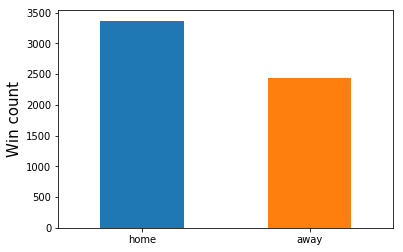

In [42]:
# Calculate what percentage of games are won by the home and away teams.

pct_home_wins = (df['winner']=='home').sum() / df['winner'].count()
pct_away_wins = 1 - pct_home_wins

# Print the home_wins percentage, and plot a barplot of home/away wins

print('The home team wins {} percent of games'.format(round(pct_home_wins,4)*100))
df['winner'].value_counts().plot(kind='bar', rot=0)
plt.ylabel('Win count', fontsize=15)
plt.suptitle('')

In [17]:
# Explore score_diff when home wins vs. when away wins.

print('When the home team wins, they win by an average of {} points.'.format(df_home['score_diff'].mean()))
print('When the away team wins, they win by an average of {} points.'.format(-1*df_away['score_diff'].mean()))

When the home team wins, they win by an average of 11.75022275022275 points.
When the away team wins, they win by an average of 10.122994652406417 points.


### TREND 2: What effect does rebounding have on who wins the game?

Text(0.5,0.98,'')

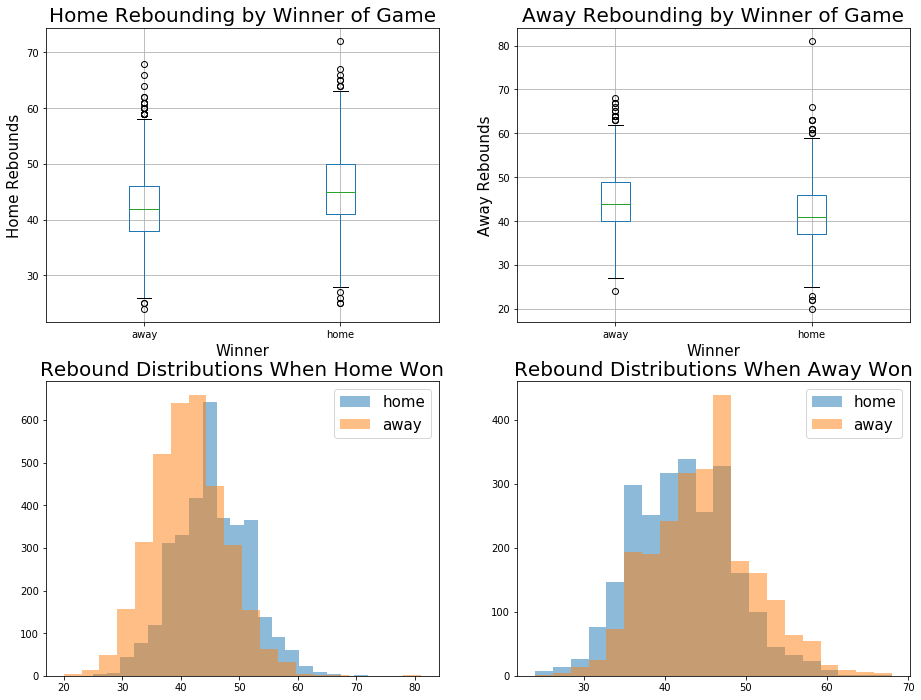

In [514]:
# Explore distributions of rebounds for home and away teams

fig, axes = plt.subplots(2,2, figsize=(15,12))

df.boxplot('home.statistics.rebounds', by='winner', ax=axes[0,0])
axes[0,0].set_title('Home Rebounding by Winner of Game', fontsize=20)
axes[0,0].set_xlabel('Winner', fontsize=15)
axes[0,0].set_ylabel('Home Rebounds', fontsize=15)

df.boxplot('away.statistics.rebounds', by='winner', ax=axes[0,1])
axes[0,1].set_title('Away Rebounding by Winner of Game', fontsize=20)
axes[0,1].set_xlabel('Winner', fontsize=15)
axes[0,1].set_ylabel('Away Rebounds', fontsize=15)

axes[1,0].hist(df_home['home.statistics.rebounds'], label='home', alpha=0.5, bins=20)
axes[1,0].hist(df_home['away.statistics.rebounds'], label='away', alpha=0.5, bins=20)
axes[1,0].set_title('Rebound Distributions When Home Won', fontsize=20)
axes[1,0].legend(fontsize=15)

axes[1,1].hist(df_away['home.statistics.rebounds'], label='home', alpha=0.5, bins=20)
axes[1,1].hist(df_away['away.statistics.rebounds'], label='away', alpha=0.5, bins=20)
axes[1,1].set_title('Rebound Distributions When Away Won', fontsize=20)
axes[1,1].legend(fontsize=15)

plt.suptitle('')

In [513]:
# Explore correlations involving rebounds and points for both teams

print('The correlation between home rebounds and home points is: {}'.format(pearson_r(df['home.statistics.rebounds'],df['home.points'])))
print('The correlation between home rebounds and away points is: {}'.format(pearson_r(df['home.statistics.rebounds'],df['away.points'])))
print('The correlation between away rebounds and away points is: {}'.format(pearson_r(df['away.statistics.rebounds'],df['away.points'])))
print('The correlation between away rebounds and home points is: {}'.format(pearson_r(df['away.statistics.rebounds'],df['home.points'])))

The correlation between home rebounds and home points is: 0.11035232775188983
The correlation between home rebounds and away points is: -0.24945485530954833
The correlation between away rebounds and away points is: 0.10673870856967976
The correlation between away rebounds and home points is: -0.23388353137458384


#### Offensive rebound analysis

In [560]:
# Explore correlations between offensive rebounds and other numerical columns

for col in df.describe().columns:
    
    print('The correlation between home offensive rebounds and {} is: {}'.format(col, pearson_r(df['home.statistics.offensive_rebounds'],df[col])))

The correlation between home offensive rebounds and away.points is: 0.022718686392882062
The correlation between home offensive rebounds and home.points is: -0.015344047119018019
The correlation between home offensive rebounds and home.statistics.assists is: -0.1198202140235673
The correlation between home offensive rebounds and home.statistics.assists_turnover_ratio is: -0.08861352158782196
The correlation between home offensive rebounds and home.statistics.blocks is: 0.01686453016472058
The correlation between home offensive rebounds and home.statistics.defensive_rebounds is: -0.04167551447336459
The correlation between home offensive rebounds and home.statistics.fast_break_pts is: -0.0009191647981993404
The correlation between home offensive rebounds and home.statistics.field_goals_att is: 0.49892156212326766
The correlation between home offensive rebounds and home.statistics.field_goals_made is: -0.008095412209996591
The correlation between home offensive rebounds and home.statisti

### TREND 3: What effect do assists have on who wins the game?

Text(0.5,0.98,'')

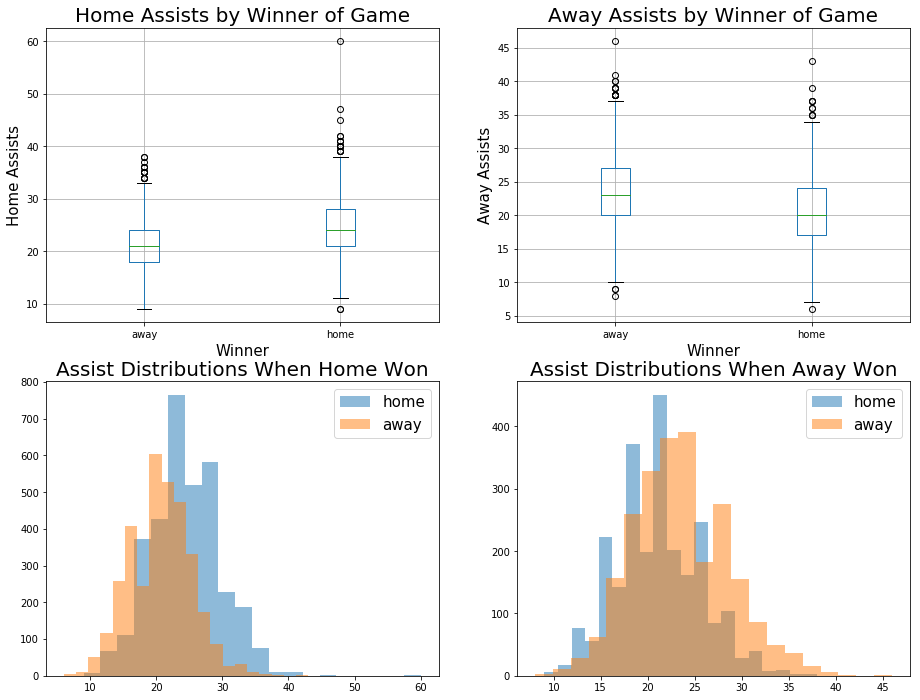

In [521]:
# Explore distributions of assists for home and away teams

fig, axes = plt.subplots(2,2, figsize=(15,12))

df.boxplot('home.statistics.assists', by='winner', ax=axes[0,0])
axes[0,0].set_title('Home Assists by Winner of Game', fontsize=20)
axes[0,0].set_xlabel('Winner', fontsize=15)
axes[0,0].set_ylabel('Home Assists', fontsize=15)

df.boxplot('away.statistics.assists', by='winner', ax=axes[0,1])
axes[0,1].set_title('Away Assists by Winner of Game', fontsize=20)
axes[0,1].set_xlabel('Winner', fontsize=15)
axes[0,1].set_ylabel('Away Assists', fontsize=15)

axes[1,0].hist(df_home['home.statistics.assists'], label='home', alpha=0.5, bins=20)
axes[1,0].hist(df_home['away.statistics.assists'], label='away', alpha=0.5, bins=20)
axes[1,0].set_title('Assist Distributions When Home Won', fontsize=20)
axes[1,0].legend(fontsize=15)

axes[1,1].hist(df_away['home.statistics.assists'], label='home', alpha=0.5, bins=20)
axes[1,1].hist(df_away['away.statistics.assists'], label='away', alpha=0.5, bins=20)
axes[1,1].set_title('Assist Distributions When Away Won', fontsize=20)
axes[1,1].legend(fontsize=15)

plt.suptitle('')

In [516]:
# Explore correlations involving assists and points for both teams

print('The correlation between home assists and home points is: {}'.format(pearson_r(df['home.statistics.assists'],df['home.points'])))
print('The correlation between home assists and away points is: {}'.format(pearson_r(df['home.statistics.assists'],df['away.points'])))
print('The correlation between away assists and away points is: {}'.format(pearson_r(df['away.statistics.assists'],df['away.points'])))
print('The correlation between away assists and home points is: {}'.format(pearson_r(df['away.statistics.assists'],df['home.points'])))

The correlation between home assists and home points is: 0.5801130863606341
The correlation between home assists and away points is: 0.10741154891713386
The correlation between away assists and away points is: 0.5618309633443603
The correlation between away assists and home points is: 0.16131404391623383


### TREND 4: What effect do steals have on who wins the game?

Text(0.5,0.98,'')

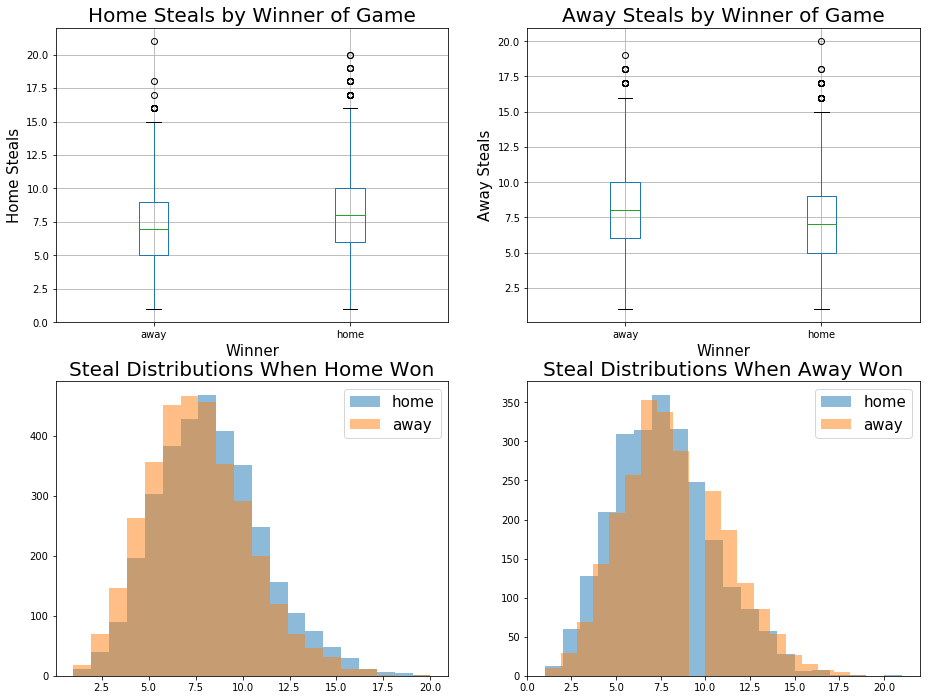

In [543]:
# Explore distributions of steals for home and away teams

fig, axes = plt.subplots(2,2, figsize=(15,12))

df.boxplot('home.statistics.steals', by='winner', ax=axes[0,0])
axes[0,0].set_title('Home Steals by Winner of Game', fontsize=20)
axes[0,0].set_xlabel('Winner', fontsize=15)
axes[0,0].set_ylabel('Home Steals', fontsize=15)

df.boxplot('away.statistics.steals', by='winner', ax=axes[0,1])
axes[0,1].set_title('Away Steals by Winner of Game', fontsize=20)
axes[0,1].set_xlabel('Winner', fontsize=15)
axes[0,1].set_ylabel('Away Steals', fontsize=15)

axes[1,0].hist(df_home['home.statistics.steals'], label='home', alpha=0.5, bins=20)
axes[1,0].hist(df_home['away.statistics.steals'], label='away', alpha=0.5, bins=20)
axes[1,0].set_title('Steal Distributions When Home Won', fontsize=20)
axes[1,0].legend(fontsize=15)

axes[1,1].hist(df_away['home.statistics.steals'], label='home', alpha=0.5, bins=20)
axes[1,1].hist(df_away['away.statistics.steals'], label='away', alpha=0.5, bins=20)
axes[1,1].set_title('Steal Distributions When Away Won', fontsize=20)
axes[1,1].legend(fontsize=15)

plt.suptitle('')

In [541]:
# Explore correlations involving steals and points for both teams

print('The correlation between home steals and home points is: {}'.format(pearson_r(df['home.statistics.steals'],df['home.points'])))
print('The correlation between home steals and away points is: {}'.format(pearson_r(df['home.statistics.steals'],df['away.points'])))
print('The correlation between away steals and away points is: {}'.format(pearson_r(df['away.statistics.steals'],df['away.points'])))
print('The correlation between away steals and home points is: {}'.format(pearson_r(df['away.statistics.steals'],df['home.points'])))

The correlation between home steals and home points is: 0.13745176010570015
The correlation between home steals and away points is: -0.08288750395474591
The correlation between away steals and away points is: 0.09549059101281955
The correlation between away steals and home points is: -0.04675467516467229


In [566]:
# Explore the correlation between steals and fast break points

print('The correlation between home steals and home fast break points is: {}'.format(pearson_r(df['home.statistics.steals'], df['home.statistics.fast_break_pts'])))
print('The correlation between away steals and away fast break points is: {}'.format(pearson_r(df['away.statistics.steals'], df['away.statistics.fast_break_pts'])))

The correlation between home steals and home fast break points is: 0.3021823833192876
The correlation between away steals and away fast break points is: 0.3145228757961193


### TREND 5: What effect do blocks have on who wins the game?

Text(0.5,0.98,'')

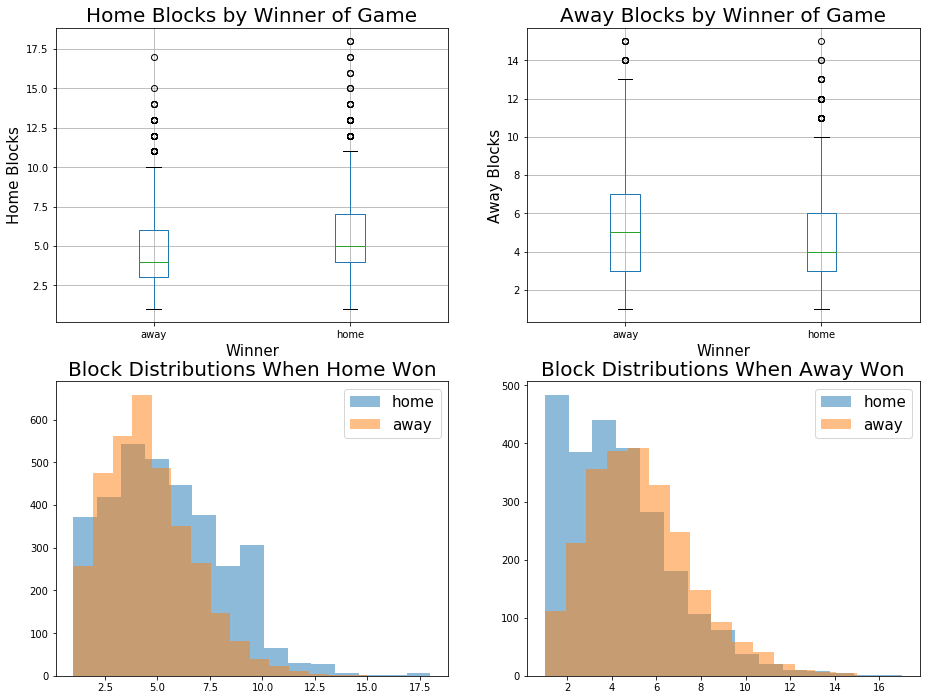

In [548]:
# Explore distributions of blocks for home and away teams

fig, axes = plt.subplots(2,2, figsize=(15,12))

df.boxplot('home.statistics.blocks', by='winner', ax=axes[0,0])
axes[0,0].set_title('Home Blocks by Winner of Game', fontsize=20)
axes[0,0].set_xlabel('Winner', fontsize=15)
axes[0,0].set_ylabel('Home Blocks', fontsize=15)

df.boxplot('away.statistics.blocks', by='winner', ax=axes[0,1])
axes[0,1].set_title('Away Blocks by Winner of Game', fontsize=20)
axes[0,1].set_xlabel('Winner', fontsize=15)
axes[0,1].set_ylabel('Away Blocks', fontsize=15)

axes[1,0].hist(df_home['home.statistics.blocks'], label='home', alpha=0.5, bins=15)
axes[1,0].hist(df_home['away.statistics.blocks'], label='away', alpha=0.5, bins=15)
axes[1,0].set_title('Block Distributions When Home Won', fontsize=20)
axes[1,0].legend(fontsize=15)

axes[1,1].hist(df_away['home.statistics.blocks'], label='home', alpha=0.5, bins=15)
axes[1,1].hist(df_away['away.statistics.blocks'], label='away', alpha=0.5, bins=15)
axes[1,1].set_title('Block Distributions When Away Won', fontsize=20)
axes[1,1].legend(fontsize=15)

plt.suptitle('')

In [549]:
# Explore correlations involving blocks and points for both teams

print('The correlation between home blocks and home points is: {}'.format(pearson_r(df['home.statistics.blocks'],df['home.points'])))
print('The correlation between home blocks and away points is: {}'.format(pearson_r(df['home.statistics.blocks'],df['away.points'])))
print('The correlation between away blocks and away points is: {}'.format(pearson_r(df['away.statistics.blocks'],df['away.points'])))
print('The correlation between away blocks and home points is: {}'.format(pearson_r(df['away.statistics.blocks'],df['home.points'])))

The correlation between home blocks and home points is: 0.05762778034438131
The correlation between home blocks and away points is: -0.14382517178682322
The correlation between away blocks and away points is: 0.055512452272261585
The correlation between away blocks and home points is: -0.14372601154981077


In [568]:
print('The correlation between home blocks and away FG percentage is: {}'.format(pearson_r(df['home.statistics.blocks'],df['away.statistics.field_goals_pct'])))
print('The correlation between away blocks and home FG percentage is: {}'.format(pearson_r(df['away.statistics.blocks'],df['home.statistics.field_goals_pct'])))

The correlation between home blocks and away FG percentage is: -0.3174664629492766
The correlation between away blocks and home FG percentage is: -0.3271663129993243


### TREND 6: What effect do turnovers have on who wins the game?

Text(0.5,0.98,'')

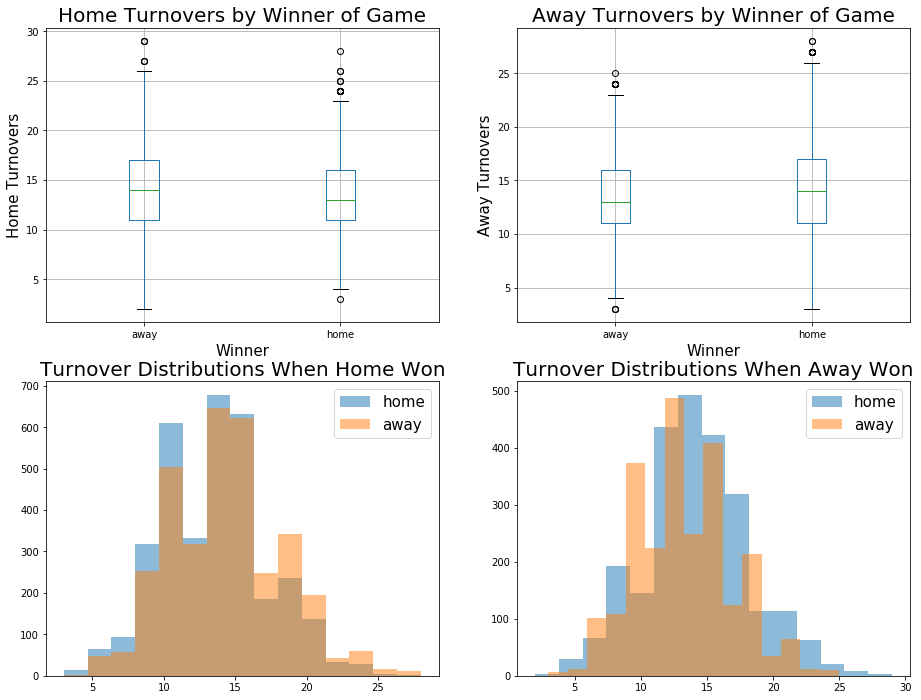

In [556]:
# Explore distributions of blocks for home and away teams

fig, axes = plt.subplots(2,2, figsize=(15,12))

df.boxplot('home.statistics.turnovers', by='winner', ax=axes[0,0])
axes[0,0].set_title('Home Turnovers by Winner of Game', fontsize=20)
axes[0,0].set_xlabel('Winner', fontsize=15)
axes[0,0].set_ylabel('Home Turnovers', fontsize=15)

df.boxplot('away.statistics.turnovers', by='winner', ax=axes[0,1])
axes[0,1].set_title('Away Turnovers by Winner of Game', fontsize=20)
axes[0,1].set_xlabel('Winner', fontsize=15)
axes[0,1].set_ylabel('Away Turnovers', fontsize=15)

axes[1,0].hist(df_home['home.statistics.turnovers'], label='home', alpha=0.5, bins=15)
axes[1,0].hist(df_home['away.statistics.turnovers'], label='away', alpha=0.5, bins=15)
axes[1,0].set_title('Turnover Distributions When Home Won', fontsize=20)
axes[1,0].legend(fontsize=15)

axes[1,1].hist(df_away['home.statistics.turnovers'], label='home', alpha=0.5, bins=15)
axes[1,1].hist(df_away['away.statistics.turnovers'], label='away', alpha=0.5, bins=15)
axes[1,1].set_title('Turnover Distributions When Away Won', fontsize=20)
axes[1,1].legend(fontsize=15)

plt.suptitle('')

In [557]:
# Explore correlations involving turnovers and points for both teams

print('The correlation between home turnovers and home points is: {}'.format(pearson_r(df['home.statistics.turnovers'],df['home.points'])))
print('The correlation between home turnovers and away points is: {}'.format(pearson_r(df['home.statistics.turnovers'],df['away.points'])))
print('The correlation between away turnovers and away points is: {}'.format(pearson_r(df['away.statistics.turnovers'],df['away.points'])))
print('The correlation between away turnovers and home points is: {}'.format(pearson_r(df['away.statistics.turnovers'],df['home.points'])))

The correlation between home turnovers and home points is: -0.08199621109529985
The correlation between home turnovers and away points is: 0.02627044984145402
The correlation between away turnovers and away points is: -0.11525516324638957
The correlation between away turnovers and home points is: 0.049941258119160045


In [570]:
# Explore the correlations between turnovers and opposing team steals and fast break points

print('The correlation between home turnovers and away fast break points is: {}'.format(pearson_r(df['home.statistics.turnovers'],df['away.statistics.fast_break_pts'])))
print('The correlation between away turnovers and home fast break points is: {}'.format(pearson_r(df['away.statistics.turnovers'],df['home.statistics.fast_break_pts'])))
print('The correlation between home turnovers and away steals is: {}'.format(pearson_r(df['home.statistics.turnovers'],df['away.statistics.steals'])))
print('The correlation between away turnovers and home steals is: {}'.format(pearson_r(df['away.statistics.turnovers'],df['home.statistics.steals'])))

The correlation between home turnovers and away fast break points is: 0.2198267929375101
The correlation between away turnovers and home fast break points is: 0.206476244542748
The correlation between home turnovers and away steals is: 0.7553749798388759
The correlation between away turnovers and home steals is: 0.7509203422139279


### TREND 7: What is more important in securing wins: two point attempts or three point attempts?

Text(0.5,0.98,'')

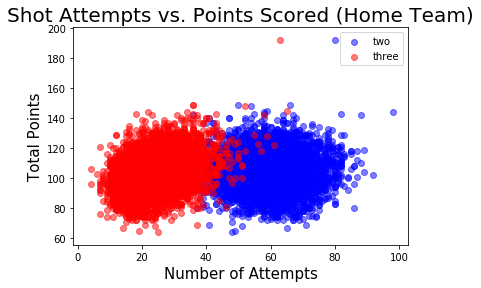

In [604]:
# Examine scatterplot of home points vs. two and three-pointers attempted

plt.scatter(df['home.statistics.two_points_att'],df['home.points'], alpha=0.5, c = 'blue', label='two')
plt.scatter(df['home.statistics.three_points_att'],df['home.points'], alpha=0.5, c = 'red', label='three')
plt.legend()
plt.xlabel('Number of Attempts', fontsize=15)
plt.ylabel('Total Points', fontsize=15)
plt.title('Shot Attempts vs. Points Scored (Home Team)', fontsize=20)
plt.suptitle('')


In [599]:
# Explore correlations between two and three pointers attempted and points scored for a given team

print('The correlation between home two-pointers attempted and home points is: {}'.format(pearson_r(df['home.statistics.two_points_att'],df['home.points'])))
print('The correlation between away two-pointers attempted and away points is: {}'.format(pearson_r(df['away.statistics.two_points_att'],df['away.points'])))
print('The correlation between home three-pointers attempted and home points is: {}'.format(pearson_r(df['home.statistics.three_points_att'],df['home.points'])))
print('The correlation between away three-pointers attempted and away points is: {}'.format(pearson_r(df['away.statistics.three_points_att'],df['away.points'])))

The correlation between home two-pointers attempted and home points is: 0.018028860741449992
The correlation between away two-pointers attempted and away points is: 0.011551186673508955
The correlation between home three-pointers attempted and home points is: 0.28620205731163073
The correlation between away three-pointers attempted and away points is: 0.2985772108823365


Text(0.5,0.98,'')

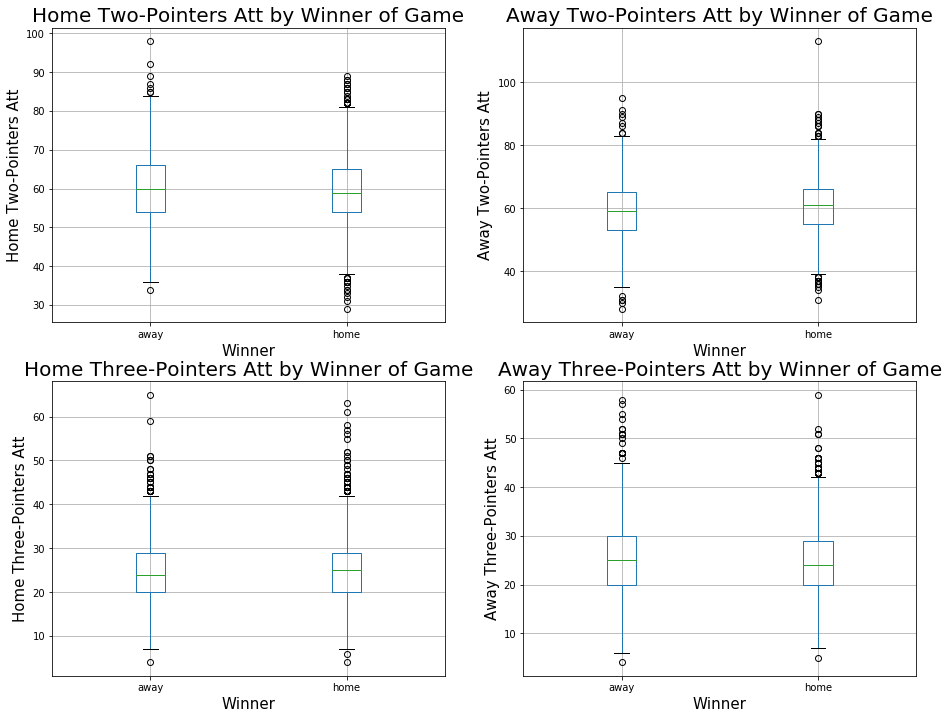

In [606]:
# Explore distributions of two and three-pointers attempted for home and away teams

fig, axes = plt.subplots(2,2, figsize=(15,12))

df.boxplot('home.statistics.two_points_att', by='winner', ax=axes[0,0])
axes[0,0].set_title('Home Two-Pointers Att by Winner of Game', fontsize=20)
axes[0,0].set_xlabel('Winner', fontsize=15)
axes[0,0].set_ylabel('Home Two-Pointers Att', fontsize=15)

df.boxplot('away.statistics.two_points_att', by='winner', ax=axes[0,1])
axes[0,1].set_title('Away Two-Pointers Att by Winner of Game', fontsize=20)
axes[0,1].set_xlabel('Winner', fontsize=15)
axes[0,1].set_ylabel('Away Two-Pointers Att', fontsize=15)

df.boxplot('home.statistics.three_points_att', by='winner', ax=axes[1,0])
axes[1,0].set_title('Home Three-Pointers Att by Winner of Game', fontsize=20)
axes[1,0].set_xlabel('Winner', fontsize=15)
axes[1,0].set_ylabel('Home Three-Pointers Att', fontsize=15)

df.boxplot('away.statistics.three_points_att', by='winner', ax=axes[1,1])
axes[1,1].set_title('Away Three-Pointers Att by Winner of Game', fontsize=20)
axes[1,1].set_xlabel('Winner', fontsize=15)
axes[1,1].set_ylabel('Away Three-Pointers Att', fontsize=15)

plt.suptitle('')

# Machine Learning to Predict Game Winner

In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Create X and y, the feature space and target variable, respectively.
# X will contain the features analyzed above, along with a select few others of interest.
# y will denote the winner of the match, with a 1 corresponding to a home win.

col_endings = ['assists', 'blocks', 'defensive_rebounds', 'free_throws_att', 'offensive_rebounds', 
              'personal_fouls', 'steals', 'three_points_att', 'turnovers', 'two_points_att']
cols = []

for col in col_endings:
    cols.append('home.statistics.' + col)
    cols.append('away.statistics.' + col)

X = df[cols]
y = (df['winner'] == 'home').values

In [25]:
# Separate data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## Machine Learning Using Offensive Statistics

In [32]:
# Create X_train_off and X_test_off, the feature space containing only offense-related features

off_col_endings = ['assists', 'free_throws_att', 'offensive_rebounds', 'three_points_att', 'turnovers', 'two_points_att']
off_cols = []

for col in off_col_endings:
    off_cols.append('home.statistics.' + col)
    off_cols.append('away.statistics.' + col)

X_train_off = X_train[off_cols].values
X_test_off = X_test[off_cols].values

In [33]:
### Random Forest Classifier

# Use GridSearchCV to tune the n_estimators (number of trees) parameter

num_trees = [10,50,100,200,500]
params = {'n_estimators': num_trees}

forest_off = RandomForestClassifier()

np.random.seed(42)

forest_off_cv = GridSearchCV(forest_off, params, cv=5)
forest_off_cv.fit(X_train_off, y_train)

forest_off_pred = forest_off_cv.predict(X_test_off)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', forest_off_cv.score(X_test_off, y_test))

print(classification_report(y_test, forest_off_pred))

The accuracy score on our test data is: 0.7408045977011494
             precision    recall  f1-score   support

      False       0.72      0.63      0.67       737
       True       0.75      0.82      0.78      1003

avg / total       0.74      0.74      0.74      1740



In [34]:
### Logistic Regression

# Use GridSearch to tune the C parameter, fit to the training data, and predict using the testing data

c_vals = np.logspace(-5,8,15)
params = {'C': c_vals}

logreg_off = LogisticRegression()

np.random.seed(42)

logreg_off_cv = GridSearchCV(logreg_off, params, cv=5)
logreg_off_cv.fit(X_train_off, y_train)

log_off_pred = logreg_off_cv.predict(X_test_off)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', logreg_off_cv.score(X_test_off, y_test))

print(classification_report(y_test, log_off_pred))


The accuracy score on our test data is: 0.7597701149425288
             precision    recall  f1-score   support

      False       0.74      0.67      0.70       737
       True       0.77      0.82      0.80      1003

avg / total       0.76      0.76      0.76      1740



In [37]:
### SVM

# Use GridSearch to tune the C, kernel, and gamma parameters, fit to the training data, and predict using the testing data.

c_vals = [0.1, 1, 10, 100]
kernel_vals = ['linear', 'rbf']
gamma_vals = [0.1, 1, 10, 100]

params = {'C': c_vals, 'kernel': kernel_vals, 'gamma': gamma_vals}

svc_off = SVC()

np.random.seed(42)

svc_off_cv = GridSearchCV(svc_off, params, cv=5)
svc_off_cv.fit(X_train_off, y_train)

svc_off_pred = svc_off_cv.predict(X_test_off)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', svc_off_cv.score(X_test_off, y_test))

print(classification_report(y_test, svc_off_pred))

The accuracy score on our test data is: 0.7614942528735632
             precision    recall  f1-score   support

      False       0.74      0.67      0.70       737
       True       0.77      0.83      0.80      1003

avg / total       0.76      0.76      0.76      1740



## Machine Learning Using Defensive Statistics

In [31]:
# Create X_train_def and X_test_def, the feature space containing only defense-related features

def_col_endings = ['blocks', 'defensive_rebounds', 'personal_fouls', 'steals']

def_cols = []

for col in def_col_endings:
    def_cols.append('home.statistics.' + col)
    def_cols.append('away.statistics.' + col)

X_train_def = X_train[def_cols].values
X_test_def = X_test[def_cols].values

In [35]:
### Random Forest Classifier

# Use GridSearchCV to tune the n_estimators (number of trees) parameter

num_trees = [10,50,100,200,500]
params = {'n_estimators': num_trees}

forest_def = RandomForestClassifier()

np.random.seed(42)

forest_def_cv = GridSearchCV(forest_def, params, cv=5)
forest_def_cv.fit(X_train_def, y_train)

forest_def_pred = forest_def_cv.predict(X_test_def)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', forest_def_cv.score(X_test_def, y_test))

print(classification_report(y_test, forest_def_pred))

The accuracy score on our test data is: 0.7879310344827586
             precision    recall  f1-score   support

      False       0.77      0.72      0.74       737
       True       0.80      0.84      0.82      1003

avg / total       0.79      0.79      0.79      1740



In [36]:
### Logistic Regression

# Use GridSearch to tune the C parameter, fit to the training data, and predict using the testing data

c_vals = np.logspace(-5,8,15)
params = {'C': c_vals}

logreg_def = LogisticRegression()

np.random.seed(42)

logreg_def_cv = GridSearchCV(logreg_def, params, cv=5)
logreg_def_cv.fit(X_train_def, y_train)

log_def_pred = logreg_def_cv.predict(X_test_def)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', logreg_def_cv.score(X_test_def, y_test))

print(classification_report(y_test, log_def_pred))


The accuracy score on our test data is: 0.8103448275862069
             precision    recall  f1-score   support

      False       0.79      0.76      0.77       737
       True       0.83      0.85      0.84      1003

avg / total       0.81      0.81      0.81      1740



In [39]:
### SVM

# Use GridSearch to tune the C, kernel, and gamma parameters, fit to the training data, and predict using the testing data.

c_vals = [0.1, 1, 10, 100]
kernel_vals = ['linear', 'rbf']
gamma_vals = [0.1, 1, 10, 100]

params = {'C': c_vals, 'kernel': kernel_vals, 'gamma': gamma_vals}

svc_def = SVC()

np.random.seed(42)

svc_def_cv = GridSearchCV(svc_def, params, cv=5)
svc_def_cv.fit(X_train_def, y_train)

svc_def_pred = svc_def_cv.predict(X_test_def)

# Print the accuracy score and classification report

print('The accuracy score on our test data is:', svc_def_cv.score(X_test_def, y_test))

print(classification_report(y_test, svc_def_pred))

The accuracy score on our test data is: 0.8091954022988506
             precision    recall  f1-score   support

      False       0.78      0.76      0.77       737
       True       0.83      0.84      0.84      1003

avg / total       0.81      0.81      0.81      1740

